In [1]:
using LinearAlgebra, Plots, Printf, SparseArrays, IterativeSolvers, LaTeXStrings

Before we look to solve the Poisson equation on a square, let's look at plotting functionality in Julia.

In [2]:
h = .1; m = convert(Int64,1/h)-1;
x = Array(h:h:1-h)
y = x
X = repeat(reshape(x, 1, :), length(y), 1)
Y = repeat(reverse(y), 1, length(x));

In [3]:
f = (x,y) -> (x,y)
U = map(f,X,Y)

9×9 Matrix{Tuple{Float64, Float64}}:
 (0.1, 0.9)  (0.2, 0.9)  (0.3, 0.9)  …  (0.7, 0.9)  (0.8, 0.9)  (0.9, 0.9)
 (0.1, 0.8)  (0.2, 0.8)  (0.3, 0.8)     (0.7, 0.8)  (0.8, 0.8)  (0.9, 0.8)
 (0.1, 0.7)  (0.2, 0.7)  (0.3, 0.7)     (0.7, 0.7)  (0.8, 0.7)  (0.9, 0.7)
 (0.1, 0.6)  (0.2, 0.6)  (0.3, 0.6)     (0.7, 0.6)  (0.8, 0.6)  (0.9, 0.6)
 (0.1, 0.5)  (0.2, 0.5)  (0.3, 0.5)     (0.7, 0.5)  (0.8, 0.5)  (0.9, 0.5)
 (0.1, 0.4)  (0.2, 0.4)  (0.3, 0.4)  …  (0.7, 0.4)  (0.8, 0.4)  (0.9, 0.4)
 (0.1, 0.3)  (0.2, 0.3)  (0.3, 0.3)     (0.7, 0.3)  (0.8, 0.3)  (0.9, 0.3)
 (0.1, 0.2)  (0.2, 0.2)  (0.3, 0.2)     (0.7, 0.2)  (0.8, 0.2)  (0.9, 0.2)
 (0.1, 0.1)  (0.2, 0.1)  (0.3, 0.1)     (0.7, 0.1)  (0.8, 0.1)  (0.9, 0.1)

In [4]:
f = (x,y) -> x*y
U = map(f,X,Y);

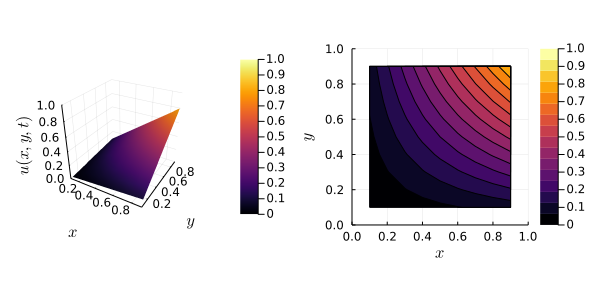

In [5]:
cl = (0,1);
width = 600
p1 = surface(x, y, U[end:-1:1,:], zaxis = [cl[1],cl[2]], clims= cl, aspectratio = 1, xlabel = L"x", ylabel = L"y", zlabel = L"u(x,y,t)")
p2 = contour(x, y, U[end:-1:1,:], clims=cl, xaxis = [0,1], yaxis = [0,1], fill = true, aspectratio = 1, xlabel = L"x", ylabel = L"y")
plot(p1, p2, layout = 2, size = (width, .5width))

Consider the Poisson equation
$$\begin{cases}
-\kappa_1 u_{xx}(x,y) - \kappa_2 u_{yy}(x,y) = f(x,y), \quad (x,y) \in [0,1] \times [0,1],\\
    u(x,0) = g_0(x),\\
    u(x,1) = g_1(x),\\
    u(0,y) = h_0(y),\\
    u(1,y) = h_1(y).
\end{cases}$$

In [6]:
m = 499
h = 1/(m + 1)
x = Array(h:h:1-h)
y = x
X = repeat(reshape(x, 1, :), length(y), 1)
Y = repeat(reverse(y), 1, length(x));

In [7]:
f = (x,y) -> exp(-(x-0.5)^2 - (y-0.5)^2)
G = (x,y) -> sin(x)*cos(y)^2 + 1/(1 + x^2)

#7 (generic function with 1 method)

In [8]:
g0 = x -> G(x,0)
g1 = x -> G(x,1)
h0 = y -> G(0,y)
h1 = y -> G(1,y)

#15 (generic function with 1 method)

In [9]:
e1 = zeros(m); e1[1] = 1.0;
em = zeros(m); em[end] = 1.0;
κ1 = 1.0; κ2 = 2.0;

In [10]:
A1 = κ1/h^2*SymTridiagonal(fill(2.0,m),fill(-1.0,m-1));
A2 = κ2/h^2*SymTridiagonal(fill(2.0,m),fill(-1.0,m-1));
F = map(f,X,Y)
F += κ1*h^(-2)*map(h1,y |> reverse)*em' + κ1*h^(-2)*map(h0,y |> reverse)*e1'
F += κ2*h^(-2)*em*map(g0,x)' + κ2*h^(-2)*e1*map(g1,x)';

In [11]:
function CG(f,b,⋄,eps::Float64;kmax = 1e6, resflag = false)
   x = 0.0*b; r = b; p = r; n = 0;
   for j = 1:kmax
        n = j
        q = f(p)
        a = (r⋄r)/(p⋄q)
        x = x + a*p
        r_old = r
        r = r - a*q
        if resflag
            println(sqrt(r⋄r))
        end
        if sqrt(r⋄r) < eps
            break
        end
        b = (r⋄r)/(r_old⋄r_old)
        p = r + b*p
        
    end
    @printf("CG took %i iterations",n)
    x
end

function CG(f,g,b,⋄,eps::Float64;kmax = 1e6, resflag = false)
   x = 0.0*b; r = b; n = 0; z = g(r);  p = z;
   for j = 1:kmax
        n = j
        w = f(p)
        a = (z⋄r)/(p⋄w)
        x = x + a*p
        r_old = r
        z_old = z
        r = r - a*w
        if resflag
            println(sqrt(r⋄r))
        end
        if sqrt(r⋄r) < eps
            break
        end
        z = g(r)
        b = (z⋄r)/(z_old⋄r_old)
        p = z + b*p 
    end
    @printf("CG took %i iterations \n",n)
    x
end

CG (generic function with 2 methods)

In [12]:
f = X -> A2*X + X*A1
function ⋄(X,Y)
    h^2*dot(X,Y)
end
g = X -> (.5A2+I/h^2)\((.5A1+I/h^2)\X')'

#21 (generic function with 1 method)

In [ ]:
U = CG(f,g,F,⋄,h^2; resflag = false)

In [ ]:
*(size(U)...)

In [ ]:
cl = (.8,1.3);
width = 800
p1 = surface(x, y, U[end:-1:1,:], zaxis = [cl[1],cl[2]], clims= cl, aspectratio = 1, xlabel = L"x", ylabel = L"y", zlabel = L"u(x,y)")
p2 = contour(x, y, U[end:-1:1,:], clims=cl, xaxis = [0,1], yaxis = [0,1], fill = true, aspectratio = 1, xlabel = L"x", ylabel = L"y")
plot(p1, p2, layout = 2, size = (width, .5width))

Using vec() and mat()

In [ ]:
*([1,2,3]...)

In [ ]:
vec = X -> vcat([X[:,i] for i = 1:m]...)
mat = x -> reshape(x, (m,m))

In [ ]:
J = kron(sparse(I,m,m),A2|>sparse) + kron(A1 |> sparse, sparse(I,m,m))

In [ ]:
U - mat(J\vec(F)) |> norm

Ill-posed problems

In [ ]:
g = x -> cos(3*x*pi) + 0.1*cos(x*pi)
α = 0.0;
β = 0.0;

In [ ]:
m = 49;
h = 1.0/(m + 1);
x = 0:h:1
A = SymTridiagonal(fill(2.0,m+2),fill(-1.0,m+1)) |> sparse
A[1,1] = 2; A[1,2] = -2
A[end,end] = 2; A[end,end-1] = -2
A *= h^(-2);

Ap = SymTridiagonal(fill(2.0,m+2),fill(-1.0,m+1));
Ap *= h^(-2);
Fp = x -> Ap\x

b = map(g,x)
b[1] += 2α/h
b[end] -= 2β/h;

In [ ]:
eigen(A |> Array).values

In [ ]:
F = x -> A*x
cc = ones(m+2); cc /= norm(cc);
G = x -> (x - cc*(cc'*x))
function ⋄(x,y)
    dot(x,y)
end

In [ ]:
dot(cc,b)

In [ ]:
U = CG(F,b,⋄,1e-6; kmax = 100000, resflag = false)

In [ ]:
U = CG(F,G,G(b),⋄,1e-6; kmax = 100000, resflag = false)

In [ ]:
norm(A*U-b)

In [ ]:
plot(x,U)
#plot!(x,cos.(3pi*x)/(9pi^2))

Another approach

In [ ]:
cc = ones(m+2);
cc[1] -= norm(cc)
cc = cc/norm(cc);
H = x -> x - 2*cc*(cc'*x)
P = x -> H(vcat([0.0],x))
Pt = x -> H(x)[2:end]

In [ ]:
F = x -> Pt(A*P(x))
function ⋄(x,y)
    dot(x,y)
end

In [ ]:
U = CG(F,Pt(b),⋄,1e-6; kmax = 10000, resflag = false)

In [ ]:
id = Matrix(I,m+1,m+1)
A_low = hcat([F(id[:,j]) for j = 1:m+1]...)

In [ ]:
κ = cond(A_low)

In [ ]:
cond(A |> Matrix)

Estimate iteration count:

$$ \|e_k\|_A \leq 2 \left( \frac{\sqrt{\kappa} -1}{\sqrt{\kappa + 1}} \right)^k.$$

To acheive $\epsilon$ accuracy

$$ k \leq  \frac{\log(\epsilon /2)}{\log\left( \frac{\sqrt{\kappa} -1}{\sqrt{\kappa + 1}} \right)}.$$

In [ ]:
log(1e-6/2)/log((sqrt(κ)-1)/(sqrt(κ)+1))

In [ ]:
κ = cond(kron(A_low,Matrix(I,m+1,m+1)) + kron(Matrix(I,m+1,m+1),A_low))

In [ ]:
log(1e-6/2)/log((sqrt(κ)-1)/(sqrt(κ)+1))

In [ ]:
CG(x -> Ap*x,rand(m+2),⋄,1e-6;resflag = true)

In [ ]:
cond(Ap |> Matrix)

In [ ]:
CG(X -> A_low*X + X*A_low, randn(m+1,m+1), ⋄, 1e-6)